In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
from collections import Counter
from sklearn.metrics import *
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

np.random.seed(52)

[nltk_data] Downloading package punkt to /home/vscode/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/vscode/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# Read clean train and test data from the path
train = pd.read_csv("../../01_Data/02_Processed/train.csv")
test = pd.read_csv("../../01_Data/02_Processed/test.csv")


# Combining the train and test data
data=pd.concat([train,test],ignore_index=True)

In [3]:
# Perform train-test split on the 'combine' dataset
train_real_data, test_real_data = train_test_split(data, test_size=0.2, stratify=data['class'])

# Assign features and targets for both training and testing sets
x_train, y_train = train_real_data['clean_tweet'].values, train_real_data['class'].values
x_test, y_test = test_real_data['clean_tweet'].values, test_real_data['class'].values

# Display the number of rows in the training and testing sets
print('Train data rows ' + str(x_train.shape[0]))
print('Test data rows ' + str(x_test.shape[0]))

Train data rows 6400
Test data rows 1600


In [4]:
# Initialize a TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit the vectorizer on the training data to learn vocabulary and IDF weights
tfidf_vectorizer.fit(x_train)

# Transform the training and test data into TF-IDF vectors using the learned vocabulary and IDF weights
x_train_tfidf = tfidf_vectorizer.transform(x_train)  # Convert training data to TF-IDF vectors
x_test_tfidf = tfidf_vectorizer.transform(x_test)    # Convert test data to TF-IDF vectors

In [5]:
# Initialize an empty list to store all words in the training set
word_list = []

# Iterate through each sentence in the training data to collect words
for sentence in x_train:
    # Split the sentence into words and append to word_list
    word_list.extend(sentence.split())

# Remove empty strings and count occurrences of each word
corpus = Counter(word for word in word_list if word != '')

# Sort words by their frequency and select the top 3000 most frequent words
corpus_ = sorted(corpus, key=corpus.get, reverse=True)[:3000]

# Transform the selected words into TF-IDF vectors using the already fitted vectorizer
vocabvec = tfidf_vectorizer.transform(corpus_) 

### Naive Bayes Model fitting on Real World Dataset


In [6]:
from sklearn.naive_bayes import MultinomialNB

# Initialize a Multinomial Naive Bayes classifier
naive_bayes_classifier = MultinomialNB()

# Train the classifier using the TF-IDF transformed training data
naive_bayes_classifier.fit(x_train_tfidf, y_train)

# Calculate and print the accuracy of the trained model on the test data
accuracy = naive_bayes_classifier.score(x_test_tfidf, y_test)
print(f'Naive Bayes model accuracy: {accuracy * 100:.2f}%')


Naive Bayes model accuracy: 89.56%


### Model Evaluation


In [7]:
# Predict labels for the test set using the trained classifier
y_pred = naive_bayes_classifier.predict(x_test_tfidf)

# Calculate the confusion matrix based on the true labels (y_test) and predicted labels (y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Extract values from the confusion matrix for TN, FP, FN, TP
TN, FP, FN, TP = conf_matrix[0, 0], conf_matrix[0, 1], conf_matrix[1, 0], conf_matrix[1, 1]

# Calculate Specificity (True Negative Rate) and Sensitivity (True Positive Rate)
specificity = TN / (TN + FP)  # Specificity measures the proportion of actual negatives correctly predicted
sensitivity = TP / (TP + FN)  # Sensitivity measures the proportion of actual positives correctly predicted

# Print the calculated Specificity and Sensitivity
print(f"Specificity (True Negative Rate): {specificity:.4f}")
print(f"Sensitivity (True Positive Rate): {sensitivity:.4f}")

Specificity (True Negative Rate): 0.8462
Sensitivity (True Positive Rate): 0.9450


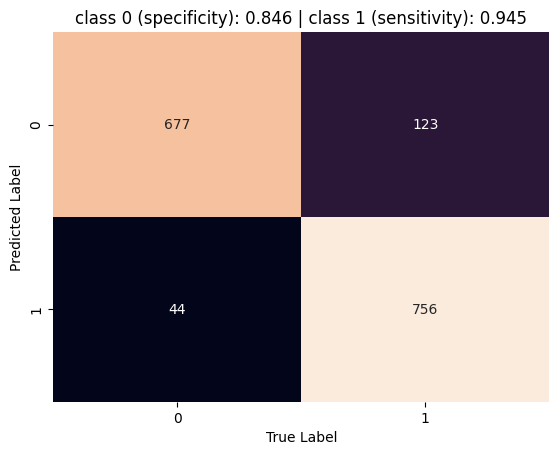

In [8]:
# Create a heatmap visualization for the confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cbar=False)

# Add title and labels to the heatmap
plt.title(f"class 0 (specificity): {specificity:0.3f} | class 1 (sensitivity): {sensitivity:0.3f}")
plt.xlabel('True Label')
plt.ylabel('Predicted Label')

plt.savefig('../../03_Plots/02_NB/01_real_cm.png')
# Display the heatmap
plt.show()

F1 Score with Naive Bayes:  0.8953699233169613
AUC with Naive Bayes:  0.8956249999999999


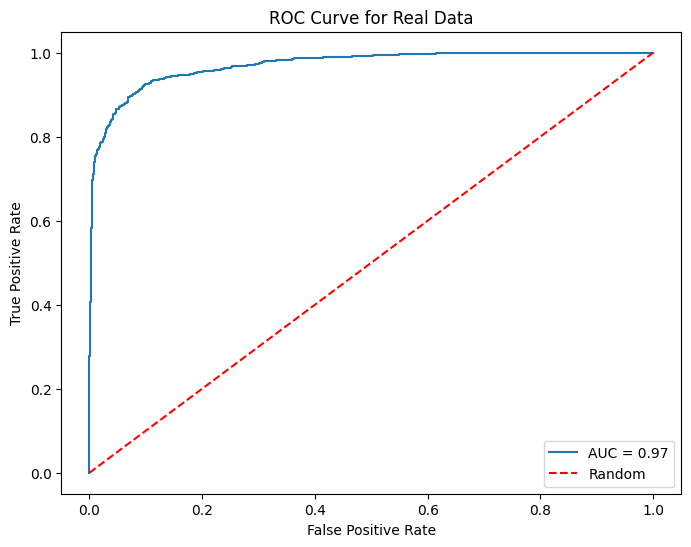

In [9]:
# Calculate the F1 Score for Naive Bayes
f1_score_naive = f1_score(y_test, y_pred, average='weighted')
print("F1 Score with Naive Bayes: ", f1_score_naive)

# Calculate the AUC (Area Under the Curve) for Naive Bayes
auc_naive = roc_auc_score(y_test, y_pred)
print("AUC with Naive Bayes: ", auc_naive)

# Obtain predicted probabilities for the positive class
y_prob = naive_bayes_classifier.predict_proba(x_test_tfidf)
fpr, tpr, thresholds = roc_curve(y_test, y_prob[:, 1])  # Considering probabilities for the positive class
roc_auc = auc(fpr, tpr)

# Plot the ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'r--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Real Data')
plt.legend()

plt.savefig('../../03_Plots/02_NB/02_real_auc.png')
plt.show()


## Synthetic Data Approach

In [10]:
# Generate probabilities of a word in the vocabulary being negative or positive
word_probabilities = naive_bayes_classifier.predict_proba(vocabvec)

In [11]:
# Initialize defaultdicts to store word probabilities for offensive and non-offensive classes
offensive_vocab = defaultdict(float)  # Dictionary for offensive class probabilities
non_offensive_vocab = defaultdict(float)  # Dictionary for non-offensive class probabilities

# Iterate through the words in the vocabulary corpus_
for i, word in enumerate(corpus_):
    # Assuming word_probabilities[i] contains the probabilities associated with word 'word'
    
    # Store the probability of the word being in the offensive class (1)
    offensive_vocab[word] = word_probabilities[i][1]  # Index 1 represents offensive class probability
    
    # Store the probability of the word being in the non-offensive class (0)
    non_offensive_vocab[word] = word_probabilities[i][0]  # Index 0 represents non-offensive class probability

In [12]:
num_reviews = 4000
num_words_per_review = np.random.randint(5, 10, size=num_reviews).tolist()

# Initialize an empty list to store synthetic offensive and non-offensive reviews
offensive_reviews = []
non_offensive_reviews = []

# Generate synthetic offensive reviews
for i in range(num_reviews):
    offensive_probs = np.array(list(offensive_vocab.values()))
    offensive_probs /= offensive_probs.sum()  # Normalize probabilities to ensure they sum up to 1
    offensive_review_words = np.random.choice(list(offensive_vocab.keys()), size=num_words_per_review[i], replace=True, p=offensive_probs)
    offensive_review = ' '.join(offensive_review_words)
    offensive_reviews.append(offensive_review)

# Generate synthetic non-offensive reviews
for i in range(num_reviews):
    non_offensive_probs = np.array(list(non_offensive_vocab.values()))
    non_offensive_probs /= non_offensive_probs.sum()  # Normalize probabilities to ensure they sum up to 1
    non_offensive_review_words = np.random.choice(list(non_offensive_vocab.keys()), size=num_words_per_review[i], replace=True, p=non_offensive_probs)
    non_offensive_review = ' '.join(non_offensive_review_words)
    non_offensive_reviews.append(non_offensive_review)

# Combine offensive and non-offensive reviews into a single list
rev_list = offensive_reviews + non_offensive_reviews

# Create corresponding sentiments (1 for offensive, 0 for non-offensive)
sen_list = [1] * num_reviews + [0] * num_reviews

# Create a DataFrame from the synthetic data
synthetic_data = pd.DataFrame({'Tweet': rev_list, 'Class': sen_list})

In [13]:
# Split the synthetic data into training and testing sets, maintaining class stratification
synthetic_train, synthetic_test = train_test_split(synthetic_data, test_size=0.2, stratify=synthetic_data['Class'])

# Assign values for training and testing data and labels
x_train, y_train = synthetic_train['Tweet'].values, synthetic_train['Class'].values
x_test, y_test = synthetic_test['Tweet'].values, synthetic_test['Class'].values

# Display the number of samples in the training and testing sets
print(f'Training data has rows:  {x_train.shape[0]}')
print(f'Testing data has rows: {x_test.shape[0]}')

Training data has rows:  6400
Testing data has rows: 1600


In [14]:
# Export the Synthetic Data to csv files
synthetic_train.to_csv("../../01_Data/02_Processed/train_syn.csv", index=False)
synthetic_test.to_csv("../../01_Data/02_Processed/test_syn.csv", index=False)

In [15]:
synthetic_train['Class'].value_counts()

Class
0    3200
1    3200
Name: count, dtype: int64

In [16]:
# Initialize a TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit the vectorizer on the training data to learn vocabulary and IDF weights
tfidf_vectorizer.fit(x_train)

# Transform the training and testing data to TF-IDF vectors
x_train_tfidf = tfidf_vectorizer.transform(x_train)
x_test_tfidf = tfidf_vectorizer.transform(x_test)

# Convert y_train and y_test to 'int64' data type
y_train = y_train.astype('int64')
y_test = y_test.astype('int64')


### Fitting model on synthetic data

In [17]:
# Initialize the Naive Bayes classifier
naive_bayes_classifier = MultinomialNB()

# Train the classifier using the synthetic training data and labels
naive_bayes_classifier.fit(x_train_tfidf, y_train)

# Calculate and print the accuracy of the Naive Bayes model on the synthetic test dataset
accuracy_synthetic = naive_bayes_classifier.score(x_test_tfidf,y_test) * 100
print(f'Naive Bayes model accuracy for synthetic dataset: {accuracy_synthetic:.2f}%')


Naive Bayes model accuracy for synthetic dataset: 74.69%


In [18]:
# Predict labels for the test set using the trained classifier
y_pred = naive_bayes_classifier.predict(x_test_tfidf)

# Calculate the confusion matrix based on the true labels (y_test) and predicted labels (y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Extract values from the confusion matrix for TN, FP, FN, TP
TN, FP, FN, TP = conf_matrix[0, 0], conf_matrix[0, 1], conf_matrix[1, 0], conf_matrix[1, 1]

# Calculate Specificity (True Negative Rate) and Sensitivity (True Positive Rate)
specificity = TN / (TN + FP)  # Specificity measures the proportion of actual negatives correctly predicted
sensitivity = TP / (TP + FN)  # Sensitivity measures the proportion of actual positives correctly predicted

# Print the calculated Specificity and Sensitivity
print(f"Specificity (True Negative Rate): {specificity:.4f}")
print(f"Sensitivity (True Positive Rate): {sensitivity:.4f}")

Specificity (True Negative Rate): 0.7312
Sensitivity (True Positive Rate): 0.7625


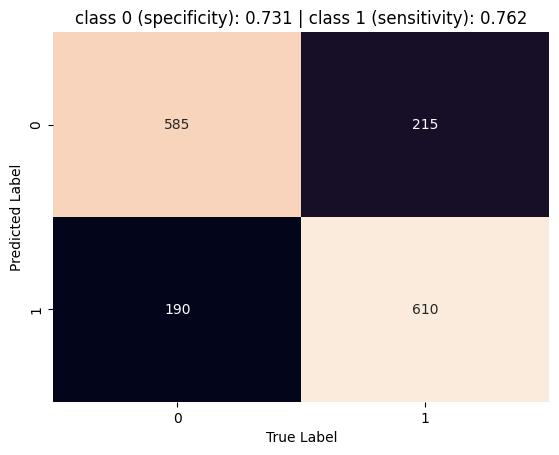

In [19]:
# Create a heatmap visualization for the confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cbar=False)

# Add title and labels to the heatmap
plt.title(f"class 0 (specificity): {specificity:0.3f} | class 1 (sensitivity): {sensitivity:0.3f}")
plt.xlabel('True Label')
plt.ylabel('Predicted Label')

plt.savefig('../../03_Plots/02_NB/03_syn_cm.png')
# Display the heatmap
plt.show()

F1 Score with Naive Bayes:  0.7468131868131869
AUC with Naive Bayes:  0.8259828125


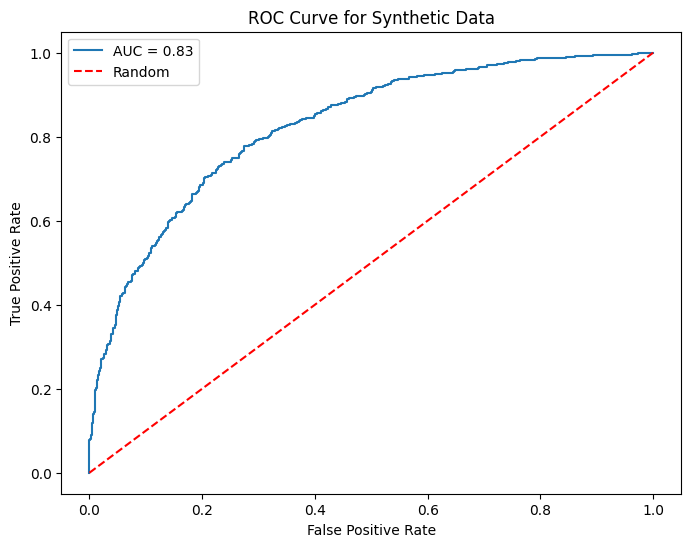

In [20]:
# Calculate the F1 Score
f1_naive = f1_score(y_test, y_pred, average='weighted')
print("F1 Score with Naive Bayes: ", f1_naive)

# Calculate the AUC
y_prob = naive_bayes_classifier.predict_proba(x_test_tfidf)
fpr, tpr, thresholds = roc_curve(y_test, y_prob[:, 1])  # Considering probabilities for the positive class
roc_auc = auc(fpr, tpr)
print("AUC with Naive Bayes: ", roc_auc)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'r--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Synthetic Data')
plt.legend()

plt.savefig('../../03_Plots/02_NB/04_syn_auc.png')
plt.show()